# Test network model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from logger import logger
from networkmodel import *
from utils import *

# Initialize empty figures dictionary
figs = {}

## Literature review

### Network connectivity matrices

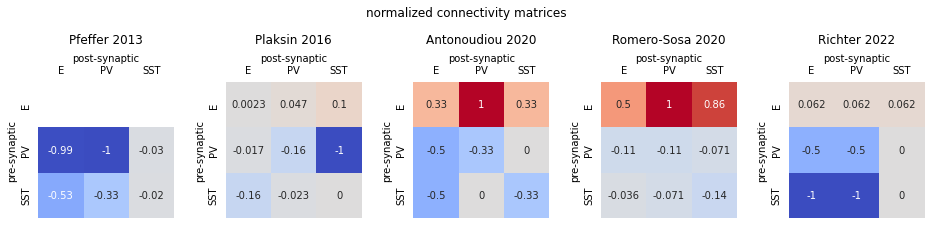

In [3]:
# Population names
populations = ['E', 'PV', 'SST']

# Connectivity matrix (from Pfeffer et al. 2013)
W_pfeffer = pd.DataFrame(
    data=[
        [np.nan, np.nan, np.nan], # E -> E, PV, SST 
        [-1, -1.01, -0.03],  # PV -> E, PV, SST
        [-0.54, -0.33, -0.02]  # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Plaksin et al. 2016)
W_plaksin = pd.DataFrame(
    data=[
        [0.002, 0.04, 0.09],      # E -> E, PV, SST 
        [-0.015, -0.135, -0.86],  # PV -> E, PV, SST
        [-0.135, -0.02, 0]        # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Antonoudiou et al. 2020)
W_antonoudiou = pd.DataFrame(
    data=[
        [10, 30, 10],   # E -> E, PV, SST 
        [-15, -10, 0],  # PV -> E, PV, SST
        [-15, 0, -10]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Romero-Sosa et al. 2020, Figure 6A,B)
W_romero_sosa = pd.DataFrame(
    data=[
        [7, 14, 12],   # E -> E, PV, SST 
        [-1.5, -1.5, -1],  # PV -> E, PV, SST
        [-0.5, -1, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Richter et al. 2022)
W_richter = pd.DataFrame(
    data=[
        [0.1, 0.1, 0.1],   # E -> E, PV, SST 
        [-0.8, -0.8, 0],  # PV -> E, PV, SST
        [-1.6, -1.6, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Comparative plot of connectivity matrices
Wdict = {
    'Pfeffer 2013': W_pfeffer,
    'Plaksin 2016': W_plaksin,
    'Antonoudiou 2020': W_antonoudiou,
    'Romero-Sosa 2020': W_romero_sosa,
    'Richter 2022': W_richter    
}
figs['connectivity comparisons'] = NetworkModel.plot_connectivity_matrix(Wdict, norm=True)

### Firing rate adaptation time constants

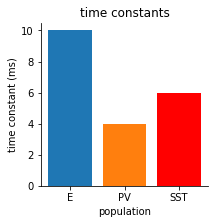

In [4]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)

figs['time constants'] = NetworkModel(tau=tau).plot_time_constants()

### Gain functions

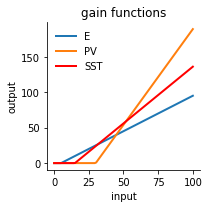

In [5]:
# Gain functions from Romero-Sosa et al. 2020
fgain = threshold_linear
fgain_params = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

figs['fgain'] = NetworkModel(fgain=fgain, fgain_params=fgain_params).plot_fgain()

## 2-population (E, SST) model 

### Define model

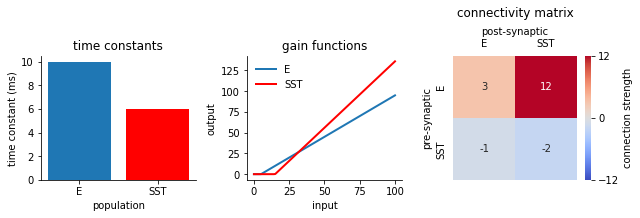

In [6]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'SST': .006
    },
    name='tau (s)'
)
populations = tau.index

# Gain function
fgain = threshold_linear

# Gain function parameters (from Romero-Sosa et al. 2020)
fgain_params = pd.DataFrame(
    data={
        'x0': [
            5,  # E 
            15  # SST
        ],
        'A': [
            1,  # E  
            1.6  # SST
        ],
    },
    index=pd.Index(populations, name='population'),
)

# Connectivity matrix
W = pd.DataFrame(
    data=[
        [3, 12],   # E -> E, SST
        [-1, -2]   # SST -> E, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Initialize model
model = NetworkModel(W=W, tau=tau, fgain=fgain, fgain_params=fgain_params)

# Check balance of excitation vs inhibition
We = model.get_net_excitation('SST')
Wi = model.get_net_inhibition('SST')
if Wi < We:
    raise ValueError(f'net inhibition strength {Wi} < net excitation strength ({We})')

# Plot model summary
figs['2-pop model'] = model.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/14 16:23:32: external input:
E      6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/14 16:23:32: NetworkModel([E, SST]): running 0.5 s long simulation
 2024/03/14 16:23:32: simulation completed in 0.026 s
 2024/03/14 16:23:32: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 38.23it/s]


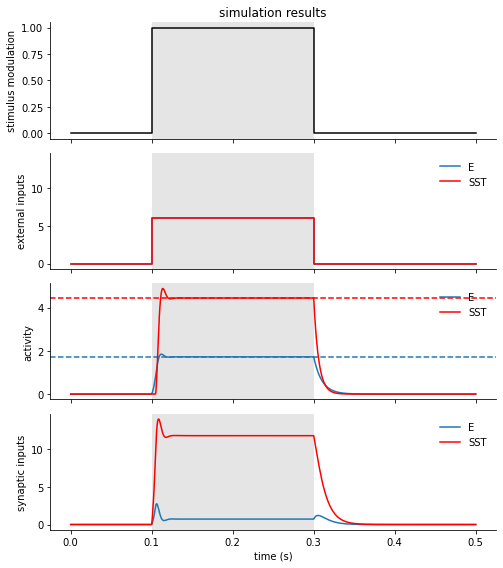

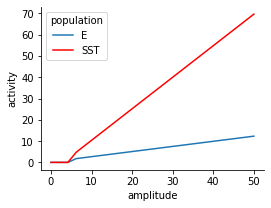

In [9]:
# External input
Ithr = fgain_params.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model.simulate(s=s)
rss = model.extract_steady_state(data)

# Plot results
figs['2-pop timeseries'] = model.plot_timeseries(data, ss=rss, add_synaptic_drive=True)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 25)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(srel, amps)

# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['2-pop ss dep norm.'] = model.plot_sweep_results(sweep_rss)

### Amplitude dependency profiles for various changes in network connectivity

In [10]:
# # Initialize empty dictionary of sweep results
# sweep_res_dict = {}

# # Vary global coupling strength
# Wscale = np.linspace(0, 10, 5)
# sweep_res_dict['Wscale'] = model.run_W_sweep(Wscale, srel, amps, pre_key=None, post_key=None)

# # For each pair of populations, vary the coupling strength
# for prekey in model.keys:
#     for postkey in model.keys:
#         key = f'W{prekey}-{postkey}'
#         Wthr = model.get_critical_value(prekey, postkey)
#         if prekey == postkey:
#             Wvec = Wthr * np.linspace(0, .9, 5)
#         else:
#             Wvec = Wthr * np.linspace(1.1, 5, 5)
#         Wvec = np.sort(Wvec)
#         sweep_res_dict[key] = model.run_W_sweep(Wvec, srel, amps, pre_key=prekey, post_key=postkey)

# # Plot results of each sweep
# norm = False
# for key, sweep_res in sweep_res_dict.items():
#     figs[f'2-pop {key} sweep'] = model.plot_sweep_results(sweep_res, norm=norm)

### Explore/optimize connectivity parameters

 2024/03/14 16:55:56: optimal connectivity matrix:
       E   SST
E    0.0  20.0
SST  0.0 -20.0
 2024/03/14 16:55:56: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 33.50it/s]


Text(0.1, 0.9, 'RMSE = 0.01')

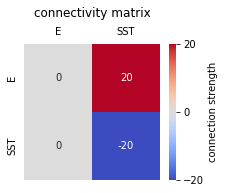

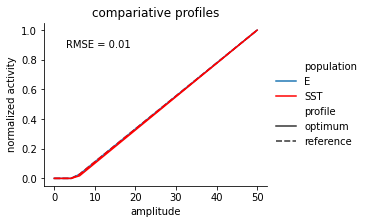

In [29]:
# Define reference population-specific activation profiles 
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fgain_params.loc['E', :]),
        'SST': threshold_linear(amps, **fgain_params.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'

# Determine whether to normalize activation profiles
norm = True

# Explore/optimize and extract optimal connectivity matrix
cost = model.explore(srel, ref_profiles, norm=norm, npersweep=3)
Wopt = model.extract_optimal_W(cost)
# Wopt = model.optimize(srel, ref_profiles, norm=True)

# Perform stimulus sweep with optimal connectivity matrix
logger.info(f'optimal connectivity matrix:\n{Wopt}')
model.W = Wopt
figs['2-pop Wopt'] = model.plot_connectivity_matrix(W=Wopt)
sweep_data = model.run_stim_sweep(srel, amps)
sweep_rss = model.extract_steady_state(sweep_data)

# Compare results to reference profiles
rmse = model.evaluate_stim_sweep(ref_profiles, sweep_data, norm=norm)
sweep_comp = pd.concat({
    'optimum': sweep_rss,
    'reference': ref_profiles
}, axis=0, names=['profile'])
figs['2-pop ss dep comp. norm.'] = model.plot_sweep_results(sweep_comp, norm=norm, style='profile')
ax = figs['2-pop ss dep comp. norm.'].axes[0]
sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)
ax.set_title(f'compariative profiles')
ax.text(0.1, 0.9, f'RMSE = {rmse:.2f}', transform=ax.transAxes, ha='left', va='top');

## 3-population (E, SST, PV) model

### Define model

 2024/03/14 10:59:29: E-PV loop strengh (0) < E-SST loop strength (12)


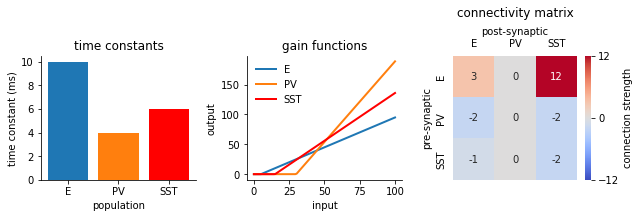

In [10]:
# Populations
populations = ['E', 'PV', 'SST']

# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)

# Gain function
fgain = threshold_linear

# Gain function parameters (from Romero-Sosa et al. 2020)
fgain_params = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

# Connectivity matrix (from Romero-Sosa et al. 2020)
# W = Wdict['Romero-Sosa 2020']

# Connectivity matrix
W = pd.DataFrame(
    data=[
        [3, 0, 12],   # E -> E, PV, SST
        [-2, 0, -2],  # PV -> E, PV, SST
        [-1, 0, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Initialize model
model = NetworkModel(W=W, tau=tau, fgain=fgain, fgain_params=fgain_params)

# Check balance of E-PV vs E-SST loops
E_PV = model.get_net_inhibition('PV')
E_SST = model.get_net_inhibition('SST')
if E_PV < E_SST:
    logger.warning(f'E-PV loop strengh ({E_PV}) < E-SST loop strength ({E_SST})')
else:
    logger.info(f'E-PV loop strengh = {E_PV}, E-SST loop strength = {E_SST}')

# Plot model summary
figs['3-pop model'] = model.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/14 10:59:29: external input:
E      6.0
PV     6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/14 10:59:29: NetworkModel([E, PV, SST]): running 0.5 s long simulation
 2024/03/14 10:59:30: simulation completed in 0.026 s
 2024/03/14 10:59:30: unstable activity in [0.10s - 0.30s] time interval


 2024/03/14 10:59:30: running stimulation sweep


100%|██████████| 50/50 [00:01<00:00, 32.53it/s]

 2024/03/14 10:59:32: amplitude = 8.2: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 10: unstable activity in [0.10s - 0.30s] time interval


 2024/03/14 10:59:32: amplitude = 17: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 20: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 28: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 37: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 38: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 39: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 40: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 41: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 42: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 43: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32: amplitude = 44: unstable activity in [0.10s - 0.30s] time interval
 2024/03/14 10:59:32:

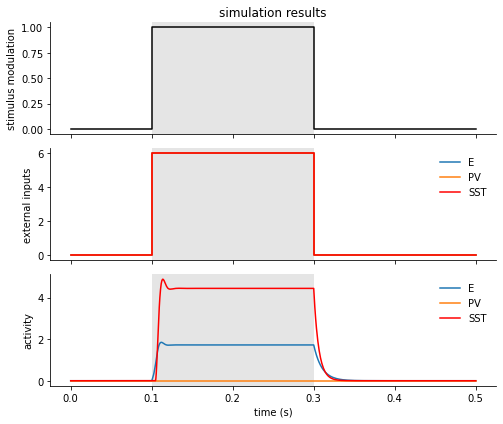

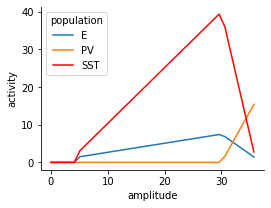

In [11]:
# External input
Ithr = fgain_params.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model.simulate(s=s)
try:
    rss = model.extract_steady_state(data)
except MetricError as e:
    logger.error(e)
    rss = None

# Plot results
figs['3-pop timeseries'] = model.plot_timeseries(data, ss=rss)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 50)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(srel, amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['3-pop ss dep norm.'] = model.plot_sweep_results(sweep_rss)

### Explore/optimize connectivity parameters

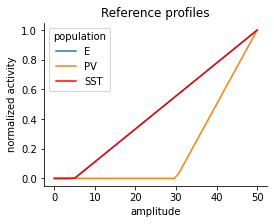

In [12]:
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fgain_params.loc['E', :]),
        'PV': threshold_linear(amps, **fgain_params.loc['PV', :]),
        'SST': threshold_linear(amps, **fgain_params.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'
figs['3-pop ref profiles'] = model.plot_sweep_results(ref_profiles, norm=True)
figs['3-pop ref profiles'].axes[0].set_title('Reference profiles');

# # Explore/optimize
# cost = model.explore(ref_profiles, srel, norm=True)
# Wopt = model.optimize(ref_profiles, srel, norm=True)